# Models using all variables

In [1]:
import pandas as pd

X_train_std = pd.read_csv("./preprocessed_datasets/X_train_std_perf.csv")
X_test_std = pd.read_csv("./preprocessed_datasets/X_test_std_perf.csv")
y_train = pd.read_csv("./preprocessed_datasets/y_train_perf.csv")
y_test = pd.read_csv("./preprocessed_datasets/y_test_perf.csv")

C:\Users\Usuario\AppData\Local\Temp\ipykernel_14848\3719717123.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Y values to array

In [2]:
import numpy as np

y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

## Lineal regression models

In [3]:
X_train_std = X_train_std.drop(["index", "ID_Zenodo"], axis=1)

X_test_std = X_test_std.drop(["index", "ID_Zenodo"], axis=1)

### Lineal Regression

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score

lr = LinearRegression(fit_intercept=True).fit(X_train_std ,y_train)
lr_r2_train = r2_score(y_train, lr.predict(X_train_std))
lr_r2_val = cross_val_score(lr, X_train_std, y_train, cv=5, scoring='r2').mean()
lr_r2_test = r2_score(y_test, lr.predict(X_test_std))

In [5]:
print(f"R2 train: {lr_r2_train}")
print(f"R2 val: {lr_r2_val}")
print(f"R2 test: {lr_r2_test}")

R2 train: 0.31399033759113504
R2 val: -9.0500994932477e+24
R2 test: 0.27831215580491886


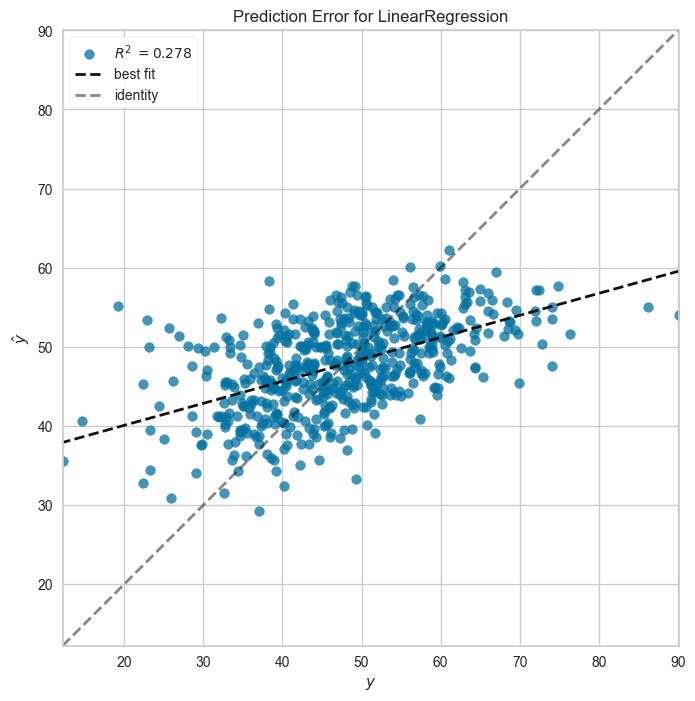

In [6]:
import matplotlib.pyplot as plt
from yellowbrick.regressor import prediction_error

plt.figure(figsize=(8,8))
visualizer = prediction_error(lr, X_test_std, y_test, is_fitted=True)

### Ridge Regression

In [7]:
from sklearn.model_selection import cross_val_score
alpha = [1e-3, 1e-2, 1e-1, 1, 100]
from sklearn.linear_model import RidgeCV
ridge_cv = RidgeCV(alphas=alpha, scoring="r2", cv=5).fit(X_train_std, y_train)
ridge_r2_test= ridge_cv.score(X_test_std, y_test)
ridge_r2_val = ridge_cv.best_score_
ridge_r2_val2 = np.mean(cross_val_score( RidgeCV(alphas=alpha, scoring="r2", cv=5), X_train_std, y_train, scoring="r2" ))
ridge_r2_train= ridge_cv.score(X_train_std, y_train)

print("Train R2: ", ridge_r2_train)
print("Validation R2: ", ridge_r2_val)
print("Validation R2: ", ridge_r2_val2)

print("Test R2: ", ridge_r2_test)
print(ridge_cv.alpha_)

Train R2:  0.3134985857439391
Validation R2:  0.2789667271673847
Validation R2:  0.2789667271673847
Test R2:  0.27858984881107784
100.0


### Lasso Regression

In [8]:
alpha = [1e-3, 1e-2, 1e-1, 1, 100]
from sklearn.linear_model import LassoCV
lasso_cv = LassoCV(cv=5, random_state=0, alphas=alpha).fit(X_train_std, y_train)
lasso_r2_test= lasso_cv.score(X_test_std, y_test)
lasso_r2_val = np.mean(cross_val_score( LassoCV(alphas=alpha, random_state=0, cv=5), X_train_std, y_train, scoring="r2" ))
lasso_r2_train= lasso_cv.score(X_train_std, y_train)

print("Train R2: ", lasso_r2_train)
print("Validation R2: ", lasso_r2_val)
print("Test R2: ", lasso_r2_test)
print(lasso_cv.alpha_)

Train R2:  0.30828946636173926
Validation R2:  0.2807244794711693
Test R2:  0.2744493984284273
0.1


C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28.04402997007128, tolerance: 15.192223079185881
  model = cd_fast.enet_coordinate_descent_gram(


In [9]:
r2_results = pd.DataFrame({'LR': lr_r2_train, 'Ridge': ridge_r2_train, 'Lasso': lasso_r2_train,}, index=['Train R2'])


print([lr_r2_val, ridge_r2_val, lasso_r2_val])
lr_r2_val = np.mean(lr_r2_val)
r2_results.loc['CV (Val) R2', :] = [lr_r2_val, ridge_r2_val, lasso_r2_val]
r2_results.loc['Test R2', :] = [lr_r2_test, ridge_r2_test, lasso_r2_test]


r2_results.loc['lambda','LR']=0
r2_results.loc['lambda','Ridge']=ridge_cv.alpha_
r2_results.loc['lambda','Lasso']=lasso_cv.alpha_
r2_results


[-9.0500994932477e+24, 0.2789667271673847, 0.2807244794711693]


,LR,Ridge,Lasso
Train R2,3.139903e-01,0.313499,0.308289
CV (Val) R2,-9.050099e+24,0.278967,0.280724
Test R2,2.783122e-01,0.278590,0.274449
lambda,0.000000e+00,100.000000,0.100000


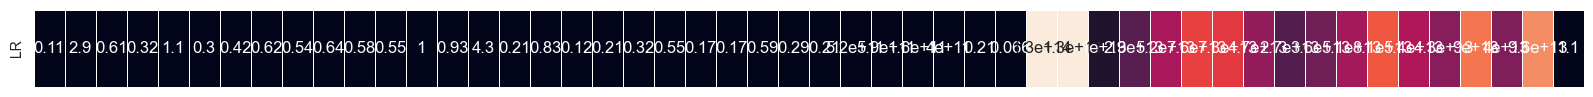

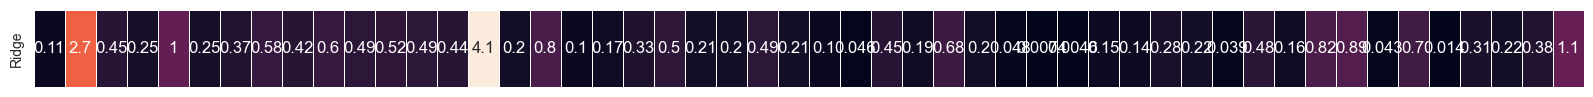

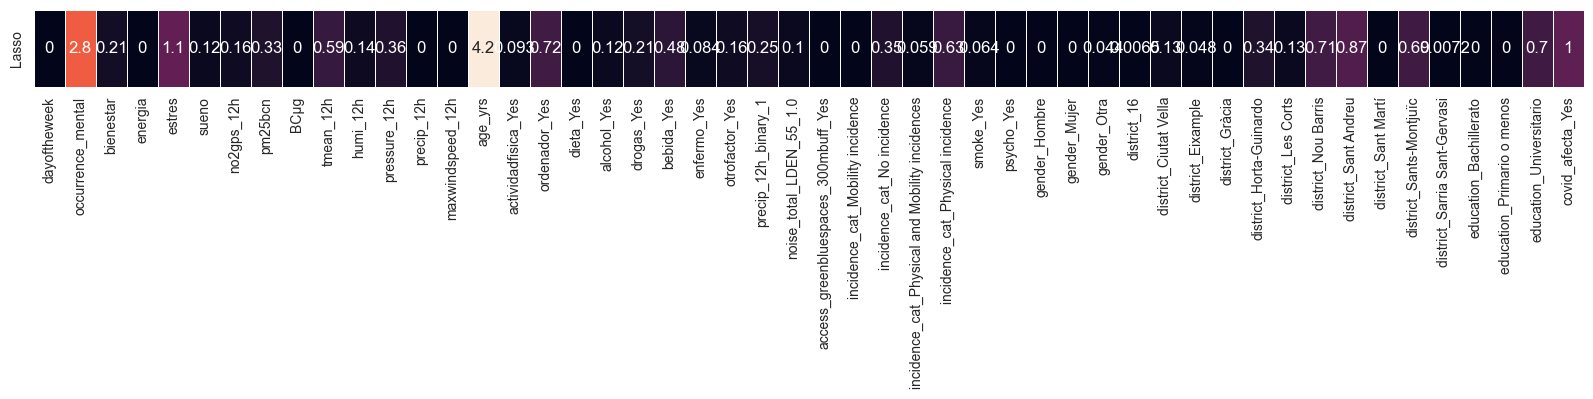

In [10]:

import matplotlib.pyplot as plt
import seaborn as sns

weights = pd.DataFrame({'LR':lr.coef_, 'Ridge':ridge_cv.coef_, 'Lasso':lasso_cv.coef_},index=X_train_std.columns)

fig, ax = plt.subplots(figsize = (20,1))
sns.heatmap(weights.T.loc[['LR'],:].abs(), annot=True, linewidths=.5, ax=ax, cbar=False, xticklabels=False);

plt.figure(figsize = (20,1))
sns.heatmap(weights.T.loc[['Ridge'],:].abs(), annot=True, linewidths=.5, cbar=False, xticklabels=False);

plt.figure(figsize = (20,1))
sns.heatmap(weights.T.loc[['Lasso'],:].abs(), annot=True, linewidths=.5, cbar=False, xticklabels=True);

# MLP (Multi Layer Perceptron)

In [11]:
# Plot leaning curves
def plot_curves(history):

  train_loss = history.history['loss']
  val_loss = history.history['val_loss']
  train_accuracy = history.history['mean_squared_error']
  val_accuracy = history.history['val_mean_squared_error']
  epochs = range(1, len(train_loss) + 1)

  fig, axes = plt.subplots(1, 2, figsize=(14, 5))

  axes[0].plot(epochs, train_loss, 'g-', label='Training Loss')
  axes[0].plot(epochs, val_loss, 'orange', label='Validation Loss')
  axes[0].set_title('Training and Validation Loss')
  axes[0].set_xlabel('Epochs')
  axes[0].set_ylabel('Loss')
  axes[0].legend()
  axes[0].grid(True)

  axes[1].plot(epochs, train_accuracy, 'g-', label='Training mean_squared_error')
  axes[1].plot(epochs, val_accuracy, 'orange', label='Validation mean_squared_error')
  axes[1].set_title('Training and Validation mean_squared_error')
  axes[1].set_xlabel('Epochs')
  axes[1].set_ylabel('mean_squared_error')
  axes[1].legend()
  axes[1].grid(True)

  plt.tight_layout()

  plt.show()


In [12]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense,  Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from keras.optimizers import SGD, Adam
from sklearn.metrics import confusion_matrix, mean_squared_error, r2_score
from tensorflow.keras import regularizers

## First iteration

In [15]:

callback = EarlyStopping(monitor='loss',patience=3)

model = Sequential([
    Dense(50, activation='relu', input_shape=(X_train_std.shape[1],)),
    Dense(1)
])
# Define the optimizer and learning rate
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)

# Compile the model
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_squared_error'])
callback = EarlyStopping(monitor='val_mean_squared_error',patience=15)

# Train the model
num_epochs = 1000
batch_size = 32
history = model.fit(X_train_std, y_train, epochs=num_epochs, batch_size=batch_size, validation_split=0.1, verbose=1, callbacks=[callback])

# Evaluate the model
y_train_pred = model.predict(X_train_std)
y_test_pred = model.predict(X_test_std)

train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print('Training MSE: {:.4f}'.format(train_mse))
print('Testing MSE: {:.4f}'.format(test_mse))
print('Training R-squared: {:.4f}'.format(train_r2))
print('Testing R-squared: {:.4f}'.format(test_r2))



Epoch 1/1000


C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2263.9736 - mean_squared_error: 2263.9736 - val_loss: 2060.6455 - val_mean_squared_error: 2060.6455
Epoch 2/1000
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2030.0264 - mean_squared_error: 2030.0264 - val_loss: 1792.9449 - val_mean_squared_error: 1792.9449
Epoch 3/1000
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step - loss: 1707.0948 - mean_squared_error: 1707.0948 - val_loss: 1478.7062 - val_mean_squared_error: 1478.7062
Epoch 4/1000
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1443.0720 - mean_squared_error: 1443.0720 - val_loss: 1136.4192 - val_mean_squared_error: 1136.4192
Epoch 5/1000
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step - loss: 1095.1633 - mean_squared_error: 1095.1633 - val_loss: 804.1697 - val_mean_squared_error: 804.1697
Epoch 6/1000
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 741.0428 - mean_squared_error: 741.0428 - val_loss: 524.8922 - val_mean_squared_error: 524.8922
Epoch 7/1000
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - l

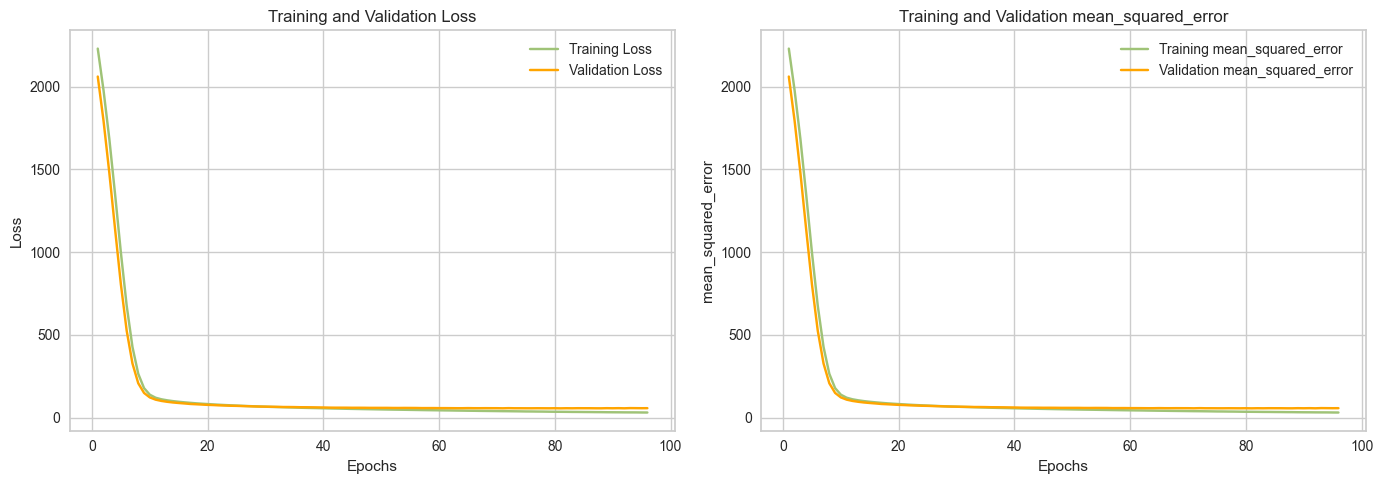

In [16]:
plot_curves(history)

## Second iteration

In [17]:
# Define the model
model = Sequential([
    Dense(256, activation='leaky_relu', input_shape=(X_train_std.shape[1],)),
    BatchNormalization(),  # Add Batch Normalization
    Dropout(0.5),           # Add Dropout for regularization
    Dense(128, activation='relu'),  # Add another hidden layer
    BatchNormalization(),  # Batch Normalization after the second hidden layer
    Dense(64, activation='relu'),   # Add another hidden layer
    Dense(1)               # Output layer
])

# Define the optimizer with momentum
learning_rate = 0.001
momentum = 0.95
optimizer = SGD(learning_rate=learning_rate, momentum=momentum)

# Compile the model
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_squared_error'])
callback = EarlyStopping(monitor='val_mean_squared_error', patience=15)

# Train the model
num_epochs = 1000
batch_size = 64  # Adjusted batch size
history = model.fit(X_train_std, y_train, epochs=num_epochs, batch_size=batch_size, validation_split=0.1, verbose=1, callbacks=[callback])

# Evaluate the model
y_train_pred = model.predict(X_train_std)
y_test_pred = model.predict(X_test_std)

train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print('Training MSE: {:.4f}'.format(train_mse))
print('Testing MSE: {:.4f}'.format(test_mse))
print('Training R-squared: {:.4f}'.format(train_r2))
print('Testing R-squared: {:.4f}'.format(test_r2))


Epoch 1/1000


C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1049.8900 - mean_squared_error: 1049.8900 - val_loss: 509.9713 - val_mean_squared_error: 509.9713
Epoch 2/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 150.5057 - mean_squared_error: 150.5057 - val_loss: 311.3015 - val_mean_squared_error: 311.3015
Epoch 3/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 100.3717 - mean_squared_error: 100.3717 - val_loss: 267.9597 - val_mean_squared_error: 267.9597
Epoch 4/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 176.7284 - mean_squared_error: 176.7284 - val_loss: 185.9946 - val_mean_squared_error: 185.9946
Epoch 5/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 121.5522 - mean_squared_error: 121.5522 - val_loss: 96.5016 - val_mean_squared_error: 96.5016
Epoch 6/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 94.1200 - mean_squared_error: 94.1200 - val_loss: 70.0584 - val_mean_squared_error: 70.0584
Epoch 7/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 70.7539 - mean_square

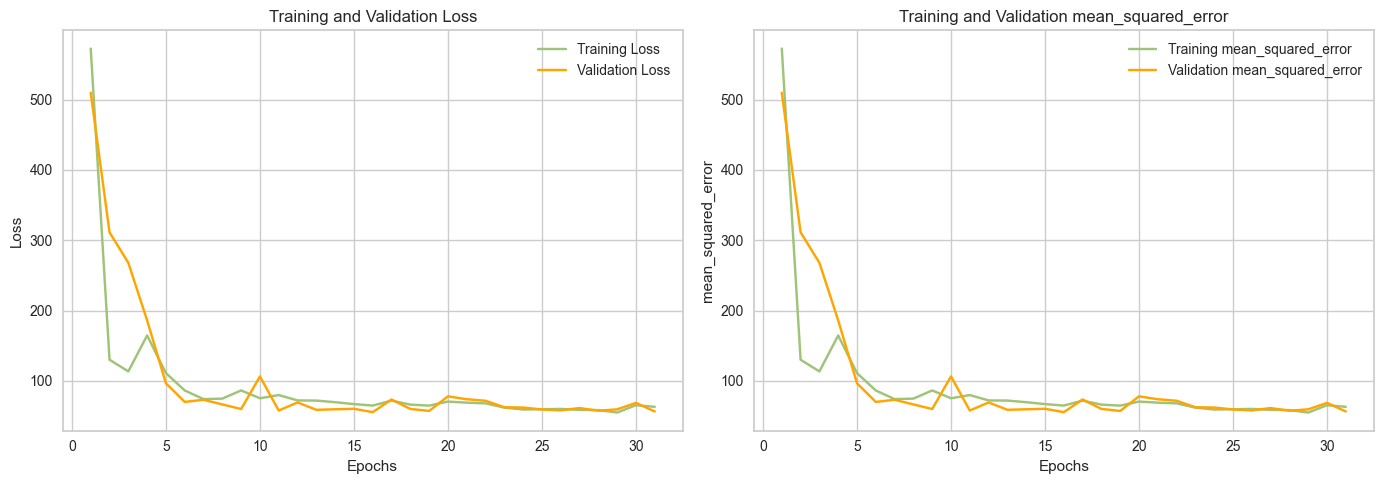

In [18]:
plot_curves(history)

## Third iteration

In [26]:
# Define the model
model = Sequential([
    Dense(256, activation='leaky_relu', input_shape=(X_train_std.shape[1],)),
    BatchNormalization(),  # Add Batch Normalization
    Dropout(0.7),           # Add Dropout for regularization
    Dense(128, activation='relu'),  # Add another hidden layer
    BatchNormalization(),  # Batch Normalization after the second hidden layer
    Dense(64, activation='relu'),   # Add another hidden layer
    Dense(1)               # Output layer
])

# Define the optimizer with momentum
learning_rate = 0.001
momentum = 0.98
optimizer = SGD(learning_rate=learning_rate, momentum=momentum)

# Use Huber loss as the loss function
def huber_loss(y_true, y_pred, delta=1.0):
    error = y_true - y_pred
    is_small_error = tf.abs(error) <= delta
    small_error_loss = 0.5 * tf.square(error)
    large_error_loss = delta * (tf.abs(error) - 0.5 * delta)
    return tf.where(is_small_error, small_error_loss, large_error_loss)

# Compile the model with Huber loss
model.compile(optimizer=optimizer, loss=huber_loss, metrics=['mean_squared_error'])
callback = EarlyStopping(monitor='val_mean_squared_error', patience=50)

# Train the model
num_epochs = 1000
batch_size = 64  # Adjusted batch size
history = model.fit(X_train_std, y_train, epochs=num_epochs, batch_size=batch_size, validation_split=0.1, verbose=1, callbacks=[callback])

# Evaluate the model
y_train_pred = model.predict(X_train_std)
y_test_pred = model.predict(X_test_std)

train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print('Training MSE: {:.4f}'.format(train_mse))
print('Testing MSE: {:.4f}'.format(test_mse))
print('Training R-squared: {:.4f}'.format(train_r2))
print('Testing R-squared: {:.4f}'.format(test_r2))


Epoch 1/1000


C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 45.2873 - mean_squared_error: 2201.8684 - val_loss: 43.2804 - val_mean_squared_error: 2018.8372
Epoch 2/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 33.6269 - mean_squared_error: 1317.7346 - val_loss: 13.7568 - val_mean_squared_error: 290.8889
Epoch 3/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 14.7097 - mean_squared_error: 363.3254 - val_loss: 23.1020 - val_mean_squared_error: 650.4653
Epoch 4/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12.1077 - mean_squared_error: 238.7958 - val_loss: 7.2303 - val_mean_squared_error: 94.2478
Epoch 5/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.6050 - mean_squared_error: 164.3414 - val_loss: 11.2376 - val_mean_squared_error: 198.1536
Epoch 6/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.9980 - mean_squared_error: 114.0705 - val_loss: 6.5561 - val_mean_squared_error: 79.2576
Epoch 7/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.4566 - mean_squared_error: 105

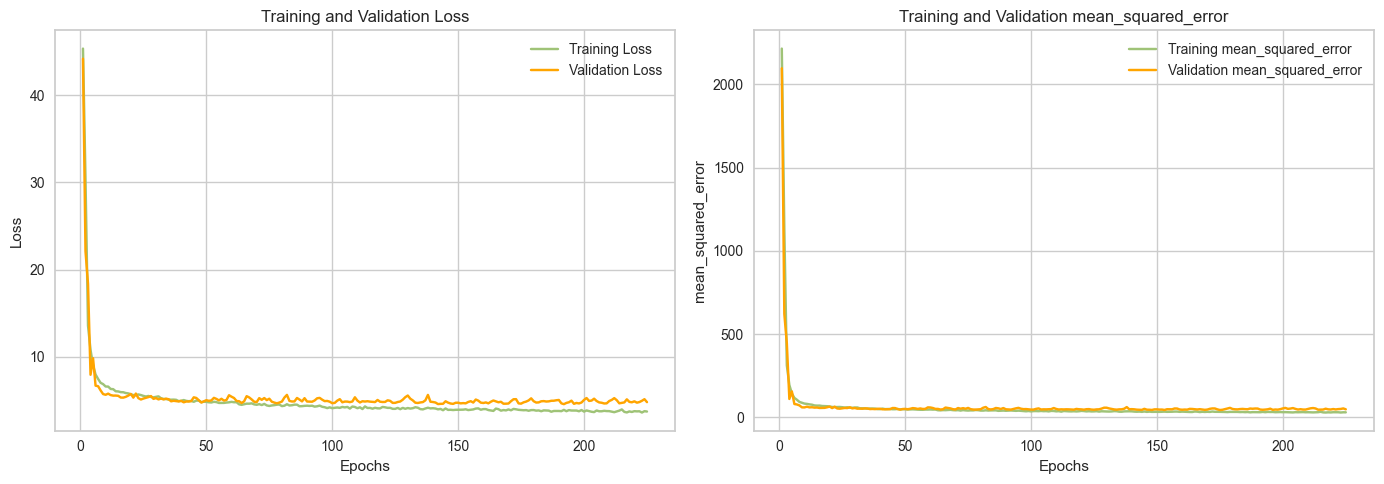

In [21]:
plot_curves(history)

## Fourth iteration

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras.losses import Huber
import tensorflow as tf
from sklearn.metrics import mean_squared_error, r2_score

# Define the model
model = Sequential([
    Dense(512, activation='relu', kernel_initializer=GlorotUniform(), input_shape=(X_train_std.shape[1],)),
    BatchNormalization(),
    Dropout(0.6),
    Dense(256, activation='relu', kernel_initializer=GlorotUniform()),
    BatchNormalization(),
    Dropout(0.6),
    Dense(128, activation='relu', kernel_initializer=GlorotUniform()),
    BatchNormalization(),
    Dropout(0.6),
    Dense(64, activation='relu', kernel_initializer=GlorotUniform()),
    BatchNormalization(),
    Dropout(0.6),
    Dense(1)
])

# Define the optimizer with a learning rate scheduler
initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
optimizer = Adam(learning_rate=lr_schedule)

# Compile the model with Huber loss
model.compile(optimizer=optimizer, loss=Huber(), metrics=['mean_squared_error'])
callback = EarlyStopping(monitor='val_mean_squared_error', patience=100)

# Train the model
num_epochs = 1000
batch_size = 256
history = model.fit(X_train_std, y_train, epochs=num_epochs, batch_size=batch_size, validation_split=0.1, verbose=1, callbacks=[callback])

# Evaluate the model
y_train_pred = model.predict(X_train_std)
y_test_pred = model.predict(X_test_std)

train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print('Training MSE: {:.4f}'.format(train_mse))
print('Testing MSE: {:.4f}'.format(test_mse))
print('Training R-squared: {:.4f}'.format(train_r2))
print('Testing R-squared: {:.4f}'.format(test_r2))


Epoch 1/1000


C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 46.6283 - mean_squared_error: 2336.7690 - val_loss: 45.7234 - val_mean_squared_error: 2236.1870
Epoch 2/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 45.8028 - mean_squared_error: 2256.8064 - val_loss: 45.0933 - val_mean_squared_error: 2179.3513
Epoch 3/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 44.0957 - mean_squared_error: 2105.9951 - val_loss: 43.8574 - val_mean_squared_error: 2071.4768
Epoch 4/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 41.0605 - mean_squared_error: 1857.4241 - val_loss: 41.2392 - val_mean_squared_error: 1855.1302
Epoch 5/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 36.9589 - mean_squared_error: 1541.2498 - val_loss: 37.7738 - val_mean_squared_error: 1613.9404
Epoch 6/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 31.3496 - mean_squared_error: 1170.4305 - val_loss: 33.5428 - val_mean_squared_error: 1379.4521
Epoch 7/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 24.2615 - mean_squared_erro

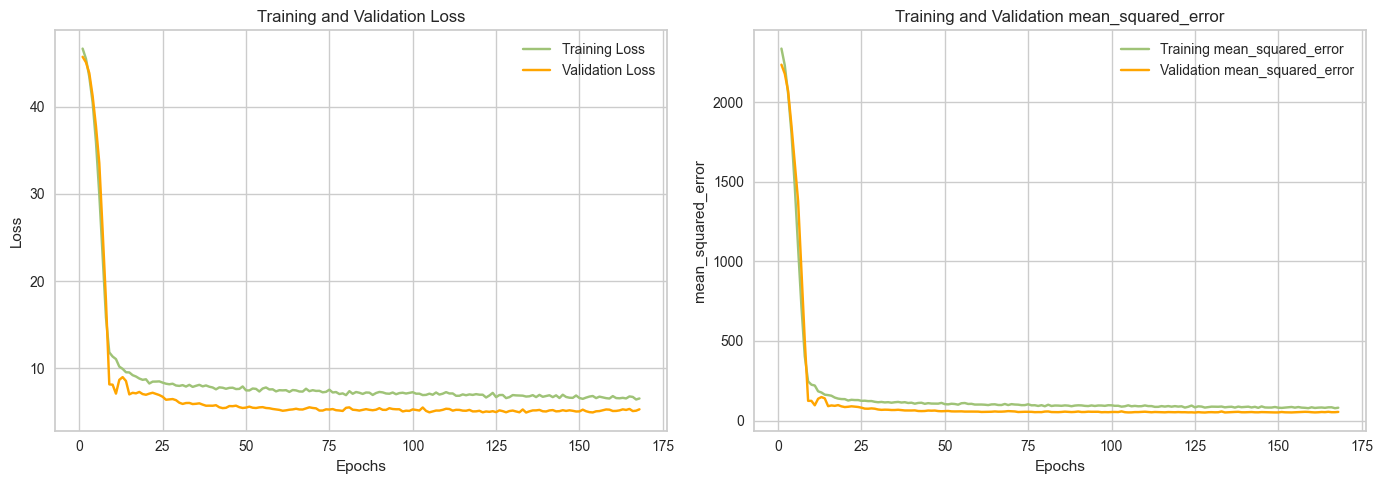

In [29]:
plot_curves(history)

### Utilitzant MLPRegressor

In [27]:
from sklearn.neural_network import MLPRegressor
regr = MLPRegressor(hidden_layer_sizes=(800, 800, 800, 400,), random_state=1, max_iter=500).fit(X_train_std, y_train)

regr.score(X_test_std, y_test)

C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


0.4198127568953245